Luis Antonio Ortega Andrés

Juan Ignacio Álvarez Trejos


In [25]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import scipy 
import matplotlib as mpl
from gmm import GaussianMixture
from IPython.display import Image as Img
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Practica Mixtura de Gausianas
Se debe implementar un modelo de mixtura de gausianas mediante el algoritmo de esperanza-maximización (EM). Este modelo se utiliza para estimar una densidad de probabilidad a partir de $N$ puntos en $D$ dimensiones, $\mathcal{D}=\{\mathbf{x}_i\}_{i=1}^N$, basado en $K$ gausianas

$$    p(\mathbf{X}) = \sum_{k=1}^K \pi_k \mathcal{N} (\mathbf{X}; \mathbf{\mu_k}, \Sigma_k) $$

donde $\pi_k$ es la probabilidad de observar un punto en la gausiana $k$ con $\sum_k=1^K \pi_k = 1$ y $\mathbf{\mu_k}, \Sigma_k$ son la media y la matriz de covarianza respectivamente de la gausiana $k$.

Para resolver este problema vamos a plantearlo con la siguiente red de bayes:

<p align="center">
  <img width="460" height="300" src="gmm.svg">
</p>

donde la variable $\mathbf{Z}$ indica la gausiana a la que pertenece cada dato codificado como 1-en-K, esto es, $\mathbf{Z}$ es un vector binario de K componenete donde una y solo una vale 1 y el resto 0. Si $z_{ik}=1$ entonces el ejemplo $\mathbf{X}_i$ pertence a la gausiana $k$. Donde 

$$ p(\mathbf{X}) = \sum_{k=1}^K p(z_k=1) p(\mathbf{X}|z_k=1) $$

donde $p(z_k=1)=\pi_k$ y $p(\mathbf{X}|z_k=1) =  \mathcal{N} (\mathbf{X}; \mathbf{\mu_k}, \Sigma_k) $.

Para aplicar el algoritmo EM tenemos que la variable no observada es la $\mathbf{Z}$ para todos los ejemplos, por lo que en el paso E debemos estimar la probabilidad de observar 1 para cada uno de las $K$ entradas en $Z$ para cada uno de los ejemplos en $\mathcal{D}$. En el paso E, estimaremos $D \times K$ valores como

<u>Paso E:</u>

$$ q_i(z_k=1) = \frac{p(z_k=1)p(\mathbf{X}|z_k=1)}{\sum_{k=1}^K p(z_k=1)p(\mathbf{X}|z_k=1)} $$

En el paso M lo que debemos hacer es estimar los parametros del modelo a partir de los datos como

<u>Paso M:</u>

$$ \pi_k = \frac{1}{N} \sum_{i=1}^N q_i(z_k=1) $$

$$ \mathbf{\mu}_k = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) \mathbf{x}_i $$

$$ \Sigma_k = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) (\mathbf{x}_i - \mathbf{\mu}_k)(\mathbf{x}_i - \mathbf{\mu}_k)^T $$

Finalmente la log-verosimilitud de los datos la podemos escribir como

$$ \log P(\mathbf{X}|\pi, \mathbf{\mu}, \Sigma) = \sum_{i=1}^N ln \left[ \sum_{k=1}^K \pi_k \mathcal{N} (\mathbf{x}_i; \mathbf{\mu_k}, \Sigma_k)  \right]$$ 

### Problemas numéricos
En la implementación de este método surgen diversos problemas numéricos
- La matriz de covarianza debe ser semi-definida positiva. Para garantizar que las estimaciones que tenemos de la matriz de covarianza lo cumplen se puede añadir un valor pequeño de regularización a la diagonal de la matriz (~1e10-5)
- El calculo de los valores de $q$ supone el cálculo de una gausiana y puede darse el caso de que para algún ejemplo y para todo $k$ el valor sea 0. Para evitar esto se puede sumar una cantidad muy pequeña siempre a todos los valores de q antes de normalizar. Adicionalmente se recomienda calcular esta probailidad como log prob y luego uilizar la función np.logsumexp para normalizar en el espacio de logprobs. 
- Finalmente para evitar problemas numéricos al invertir la matriz de covarianza se recomienda usar la desconposición de Choleski esto es: <tt>covinv = scipy.linalg.cho_solve(scipy.linalg.cho_factor(covariaza), I)</tt>, donde <tt>I</tt> es la matriz identidad


In [26]:
import matplotlib.transforms as transforms

def make_ellipse(cov, mean, ax, n_std=3.0, **kwargs):
    """
        Adaptado de: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
        
        En kwargs se pueden poner todo tipo de argumentos para dibujar la elipse. Por ejemplo
        para que la elipse sea naranja semitransparente con borde rojo sería:
            
            def make_ellipse(cov, mean, ax, n_std=3.0, facecolor='orange', edgecolor='red', alpha=0.5)
            
    """
    
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = mpl.patches.Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    
    ellipse.set_transform(transf + ax.transData)
    
    color = kwargs['edgecolor'] if 'edgecolor' in kwargs else 'red'
    
    ax.scatter(mean_x, mean_y, marker='x', c=color)
    
    return ax.add_patch(ellipse)

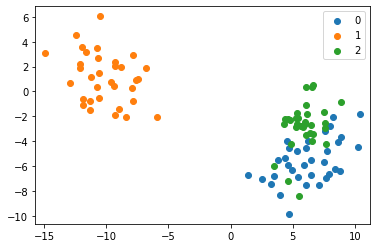

In [27]:
def generate_dataset(rotate = True, K = 3, N = 100, seed = 123):
    X, y = make_blobs(N, centers=K, random_state = seed)
    np.random.seed(seed)

    transformation = np.array([[1,0],[0,1]])

    for y_k in np.unique(y):
        if rotate:
            transformation = np.array([[(0.2+np.random.rand())*2,
                                      0.5-np.random.rand()], 
                                    [0.5-np.random.rand(), 
                                    (0.2+np.random.rand())*2]])

        X[y==y_k,:] = np.dot(X[y==y_k,:], transformation)
    return X, y

def plot_dataset(X, y, means_ = None, covs_ = None, title = None):
    fig = plt.figure()
    for i in np.unique(y): 
        mask = y == i
        plt.scatter(X[mask,0], X[mask,1],label=i)

        if means_ is not None and covs_ is not None:
            mu = gmm.means_[i,:]
            cov = gmm.covariances_[i,:]
            make_ellipse(cov, mu, fig.axes[0], facecolor='none', edgecolor='red')
    fig.axes[0].axis('equal')
    _ = plt.legend()
    if title:
        plt.title(title)
    plt.show()

X, y = generate_dataset()
plot_dataset(X, y)

# Visualización de resultados


Comenzamos ajustando un objeto de la clase GaussianMixture con 3 componentes, el mismo número que clases diferentes tenemos en el conjunto de datos, y utilizamos la inicialización mediante `KMeans`. Una vez predichas las nuevas etiquetas ``y``, tomamos también el vector de medias y la matriz de covarianzas.

In [28]:
gmm = GaussianMixture(n_components=3, init_params="kmeans", random_state= 123)        
pred = gmm.fit_predict(X)
means_ = gmm.means_
covs_ = gmm.covariances_

Utilizando las medias y covarianzas obtenidas por el algoritmo, podemos pintar las elipses correspondientes a cada una de las Gaussianas aprendidas. Lo hacemos mostrando tanto las etiquetas reales como las etiquetas correspondientes a la componente aprendida por el algoritmo EM.

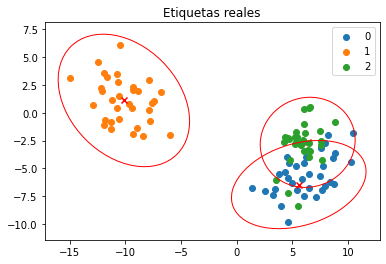

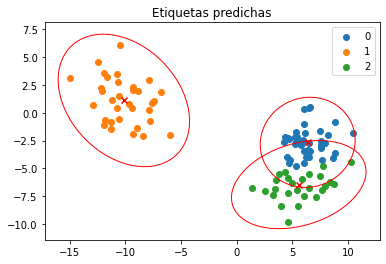

In [29]:
plot_dataset(X, y, means_, covs_, "Etiquetas reales")
plot_dataset(X, pred, means_, covs_, "Etiquetas predichas")

Como podemos ver, pese a existir cierta discrepancia en algunos elementos de la clase 2 y 0, la predicción realizada por el modelo se ajusta considerablemente bien a las etiquetas reales de los datos. Respecto a las Gaussianas aprendidas, esta claro que la corresponciente a la Clase 1 esta perfectamente delimitada, mientras que en las correspondientes a las otras dos clases, podríamos obtener covarianzas menores.

La calidad de los resultados obtenidos se debe en gran medida a la inicialización realizada, si en lugar de utilizar el resultado de `KMeans` para asignar las componentes de los elementos utilizamos la inicialización aleatoria obtenemos el siguiente resultado:

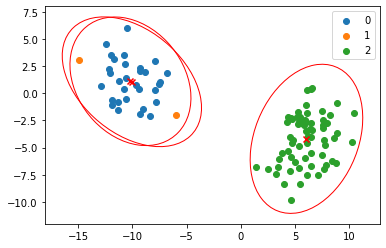

In [30]:
gmm = GaussianMixture(n_components=3, init_params="random", random_state= 123)        
pred = gmm.fit_predict(X)
means_ = gmm.means_
covs_ = gmm.covariances_
plot_dataset(X, pred, means_, covs_)

Donde uno de los clusters (el que se encontraba más separado) se aprende casi perfectamente, los otros dos clusters se han jusionado en uno solo y el último apenas existe. Esto nos da evidencia sobre lo que ya sabiamos **el algoritmo EM es muy sensible a la inicialización**.

Podemos retomar los resultados obtenidos e inspeccionar como ha evolucionado la verosimilitud de los datos con cada una de las dos inicializaciones.

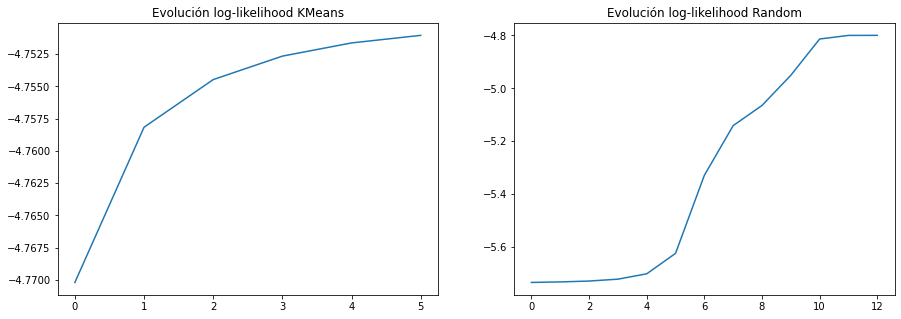

In [31]:
gmm = GaussianMixture(n_components=3, init_params="kmeans", random_state= 123)        
gmm.fit(X)
gmm2 = GaussianMixture(n_components=3, init_params="random", random_state= 123)        
gmm2.fit(X)
fig, axes = plt.subplots(1,2, figsize = (15,5))
axes[0].plot(gmm.log_probs)
axes[0].set_title("Evolución log-likelihood KMeans")
axes[1].plot(gmm2.log_probs)
axes[1].set_title("Evolución log-likelihood Random")
plt.show()

Como podemos ver en las gráficas, existen varias diferencias entre los resultados obtenidos por ambas inicializaciones. Con el uso de `KMeans`, solo se realizan 5 iteraciones del algoritmo EM mientras que con la inicialización aleatoria se realizan más del doble de iteraciones. Esto tiene sentido pues al utilizar `KMeans` ya estamos más cerca de un óptimo local del problema comparado con la inicialización aleatoria.

Otra diferencia clave es el cambio que sucede en la verosimilitud: con la inicialización aleatoria, vemos que la verosimilitud aumenta considerablemente en las etapas intermedias del algoritmo, acabando en un valor cercano a `log ll = -4.8`. Por otro lado, al utilizar `KMeans`, no obtenemos apenas una mejora en la verosimilitud de los datos. Destacamos que la verosimilitud final utilizando inicialización aleatoria es menor que la inicial utilizando `KMeans`.

## Pruebas con conjuntos más complejos.

Probamos entonces a generar un nuevo dataset con mas componentes y puntos en cada una de ellas.

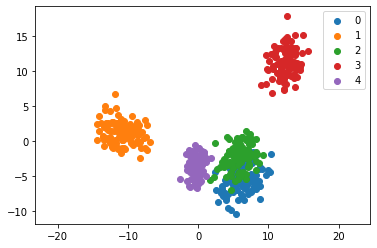

In [32]:
X, y = generate_dataset(N = 500, K = 5)
plot_dataset(X, y)

El conjunto tiene dos clusters separados de los demás y 3 muy próximos entre ellos, luego es probable que el algoritmo ``EM`` con inicialización aleatoria solo aprenda 3 o 4 clusters, agrupando los más próximos y difíciles de diferenciar.

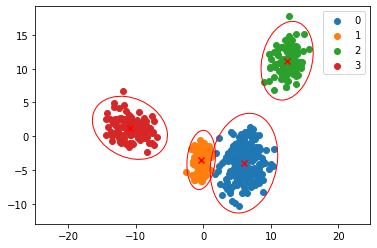

In [33]:
gmm = GaussianMixture(n_components=5, init_params="random", random_state= 123)        
pred = gmm.fit_predict(X)
means_ = gmm.means_
covs_ = gmm.covariances_
plot_dataset(X, pred, means_, covs_)

Efectivamente, vemos como en la predicción final, solo se utilizan 4 clusters para explicar los datos. Podemos utilizar la función ``fit_plot`` para crear una animación en el fichero ``gmm_anim.gif`` que permita ver la evolución de las predicciones en cada época.

In [34]:
gmm.fit_plot(X)

In [35]:
Img(url="gmm_anim.gif")

En la animación, podemos ver como pese a estar inicializado de forma aleatoria, el modelo aprende rapidamente 4 clusters diferenciados, dejando uno de ellos sin puntos que lo representen.

## Aplicación a dataset real. Iris dataset.

Tomamos la base de datos Iris de `SKlearn`.

In [36]:
X.shape

(500, 2)

Text(0, 0.5, 'Sepal width')

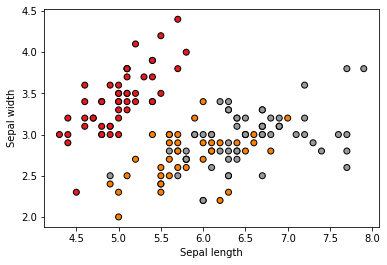

In [37]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data  # we only take the first two features.
y = iris.target

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

Entrenamos un modelo con tantas componentes como clases e inicialización `KMeans`. Como experimento, vamos a seleccionar dos características a mostrar `Sepal width` y `Sepal length` y vamos a mostrar los resultados en dicho espacio dos dimensional de entrenar la mixtura sólo utilizando estas características y las 4 disponibles.

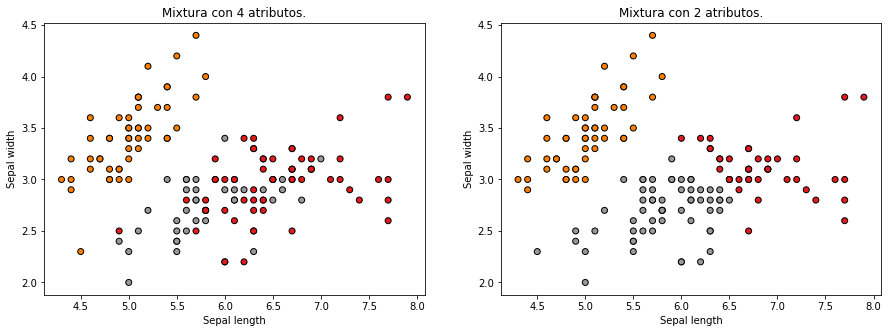

In [38]:
gmm = GaussianMixture(n_components=3, init_params="kmeans")
# Todas las características
y_pred = gmm.fit(X).predict(X)
# Solo dos características
y_pred2 = gmm.fit(X[:, :2]).predict(X[:, :2])

fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].scatter(X[:, 0], X[:, 1], c=y_pred, cmap=plt.cm.Set1,
            edgecolor='k')
axes[0].set_xlabel('Sepal length')
axes[0].set_ylabel('Sepal width')
axes[0].set_title("Mixtura con 4 atributos.")

axes[1].scatter(X[:, 0], X[:, 1], c=y_pred2, cmap=plt.cm.Set1,
            edgecolor='k')
axes[1].set_xlabel('Sepal length')
axes[1].set_ylabel('Sepal width')
axes[1].set_title("Mixtura con 2 atributos.")

plt.show()

Como podemos ver en las representaciones obtenidas, utilizar todas las componentes en el entrenamiento proporciona un etiquetado más similar al que presentan los datos originalmente, además, esto nos sirve para comprobar que el algoritmo implementado funciona correctamente con datos de mayor dimensión. 